In [1]:
import SimpleITK as sitk
import os
import pandas as pd
import numpy as np
import time
import sys
import pydicom
import shutil
%matplotlib inline
import matplotlib.pyplot as plt

In [16]:
paths = [['temp/dicoms/in', 'temp/dicoms/out', 'temp/dicoms/fat', 'temp/dicoms/water'], 
         ['temp/dicoms/b50', 'temp/dicoms/b600', 'temp/dicoms/b900', 'temp/dicoms/adc']]
series_numbers = [[1, 2, 3, 4], [5, 6, 7, 8]]
series_descriptons=  [['in', 'out', 'fat', 'water'], ['b50', 'b600', 'b900', 'ADC']]

In [17]:
def load_sitk_image_volumes(paths, series_descriptions):
    imgs = []
    readers = []
    print('--- Loading Image Volumes in SimpleITK ---')
    for g, group in enumerate(paths):
        imgs.append([])
        readers.append([])
        for i, path in enumerate(group):
            for dirName, subdirList, fileList in os.walk(path):
                verbose_path = list(set([dirName for filename in fileList if filename.lower().endswith('.dcm')]))
                if len(verbose_path):  # this code is pretty gross but it works
                    print('"' + series_descriptions[g][i] + '"', 'image volume loaded')
                    reader = sitk.ImageSeriesReader()
                    dcm_names = reader.GetGDCMSeriesFileNames(verbose_path[0])
                    reader.SetFileNames(dcm_names)
                    reader.MetaDataDictionaryArrayUpdateOn()
                    reader.LoadPrivateTagsOn()
                    imgs[g].append(reader.Execute())
                    readers[g].append(reader)
    return imgs, readers

In [18]:
imgs, readers = load_sitk_image_volumes(paths, series_descriptons)

--- Loading Image Volumes in SimpleITK ---
"in" image volume loaded
"out" image volume loaded
"fat" image volume loaded
"water" image volume loaded
"b50" image volume loaded
"b600" image volume loaded
"b900" image volume loaded
"ADC" image volume loaded


In [19]:
def myshow2(imgs, titles):
    n_col = max([len(group) for group in imgs])
    n_row = len(imgs)
    fig, axs = plt.subplots(n_row, n_col, figsize=(12, 12))
    fig.set_dpi(100)
    # fig.set_size_inches(20,6)
    for g, group in enumerate(imgs):
        i = 0
        for img, ax in (zip(group, axs[g])):
            spacing = img.GetSpacing()
            x_space = spacing[0]
            z_space = spacing[2]
            y = int(img.GetHeight()/1.7)
            nda_y = sitk.GetArrayViewFromImage(img)[:,y,:]
            x_size = nda_y.shape[1]
            z_size = nda_y.shape[0]
            extent = (0, x_size*x_space, z_size*z_space, 0)
            ax.set_title(titles[g][i])
            t = ax.imshow(nda_y,extent=extent,interpolation=None, origin='lower', 
                  cmap='Greys_r', vmin=nda_y.min(), vmax=nda_y.max()/2)
            i += 1
    fig.savefig("scans.pdf", bbox_inches='tight')
    for ax in axs.flatten():
        if not ax.images:
            ax.axis('off')

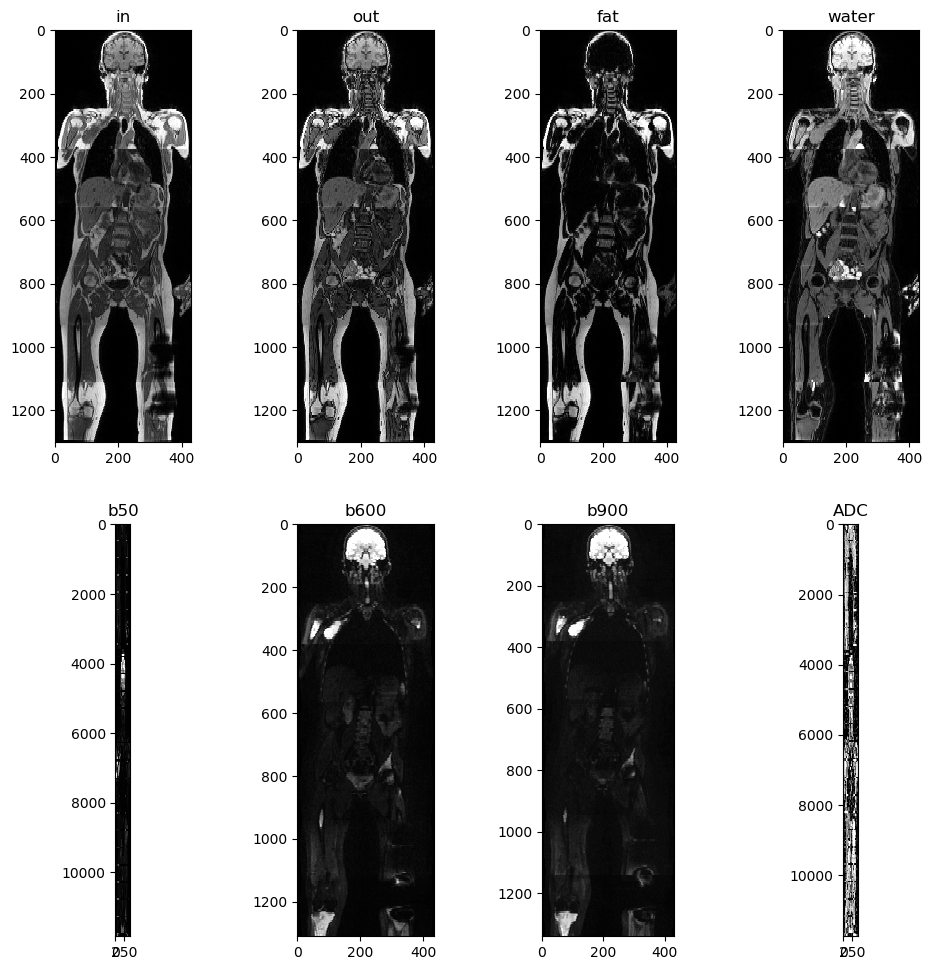

In [20]:
myshow2(imgs, series_descriptons)

In [23]:
def match_fovs_2(image_volumes, series_descriptons):
    imgs = [img for group in image_volumes for img in group]  # flattens nested list
    origin = tuple(np.max([img.GetOrigin()[i] for img in imgs]) for i in range(3))
    fov = tuple(np.min([img.GetSize()[i]*img.GetSpacing()[i] for img in imgs]) for i in range(3))
    directions = [img.GetDirection() for img in imgs]
    direction = max(set(directions), key = directions.count)

    imgs_new = []

    for g, group in enumerate(image_volumes):
        spacings = [img.GetSpacing() for img in group]
        ref_spacing = max(set(spacings), key = spacings.count)

        ref_size = tuple(int(round(fov/spacing, 0)) for fov, spacing in zip(fov, ref_spacing))

        resample = sitk.ResampleImageFilter()
        resample.SetOutputSpacing(ref_spacing)
        resample.SetSize(ref_size)
        resample.SetOutputDirection(direction)
        resample.SetOutputOrigin(origin)
        resample.SetTransform(sitk.Transform())
        resample.SetDefaultPixelValue(3)
        resample.SetInterpolator(sitk.sitkLinear)
        
        print('Resampling Image Volumes:')
        imgs_new.append([resample.Execute(img) for img in group])
        
        for i, img in enumerate(group):
            print('-------',series_descriptons[g][i],'-------')
            print('Origin:', img.GetOrigin(), '---->', origin)
            print('Direction:', img.GetDirection(), '---->', direction)
            print('Spacing:', img.GetSpacing(), '---->', ref_spacing)
            print('FOV:', tuple(sp*si for sp, si in zip(img.GetSpacing(), img.GetSize())), 
                  '---->', fov)
            print('Size:', img.GetSize(), '---->', ref_size)
            
    return imgs_new

In [24]:
imgs_new_2 = match_fovs_2(imgs, series_descriptons)

Resampling Image Volumes:
------- in -------
Origin: (-218.72946166992188, -163.67332458496094, -1102.43017578125) ----> (-218.72946166992188, -163.67332458496094, -1102.43017578125)
Direction: (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0) ----> (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
Spacing: (0.8398, 0.8398, 5.0) ----> (0.8398, 0.8398, 5.0)
FOV: (429.9776, 322.4832, 1300.0) ----> (429.9776, 322.4832, 1300.0)
Size: (512, 384, 260) ----> (512, 384, 260)
------- out -------
Origin: (-218.72946166992188, -163.67332458496094, -1102.43017578125) ----> (-218.72946166992188, -163.67332458496094, -1102.43017578125)
Direction: (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0) ----> (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
Spacing: (0.8398, 0.8398, 5.0) ----> (0.8398, 0.8398, 5.0)
FOV: (429.9776, 322.4832, 1300.0) ----> (429.9776, 322.4832, 1300.0)
Size: (512, 384, 260) ----> (512, 384, 260)
------- fat -------
Origin: (-218.72946166992188, -163.67332458496094, -1102.43017578125) ----> (

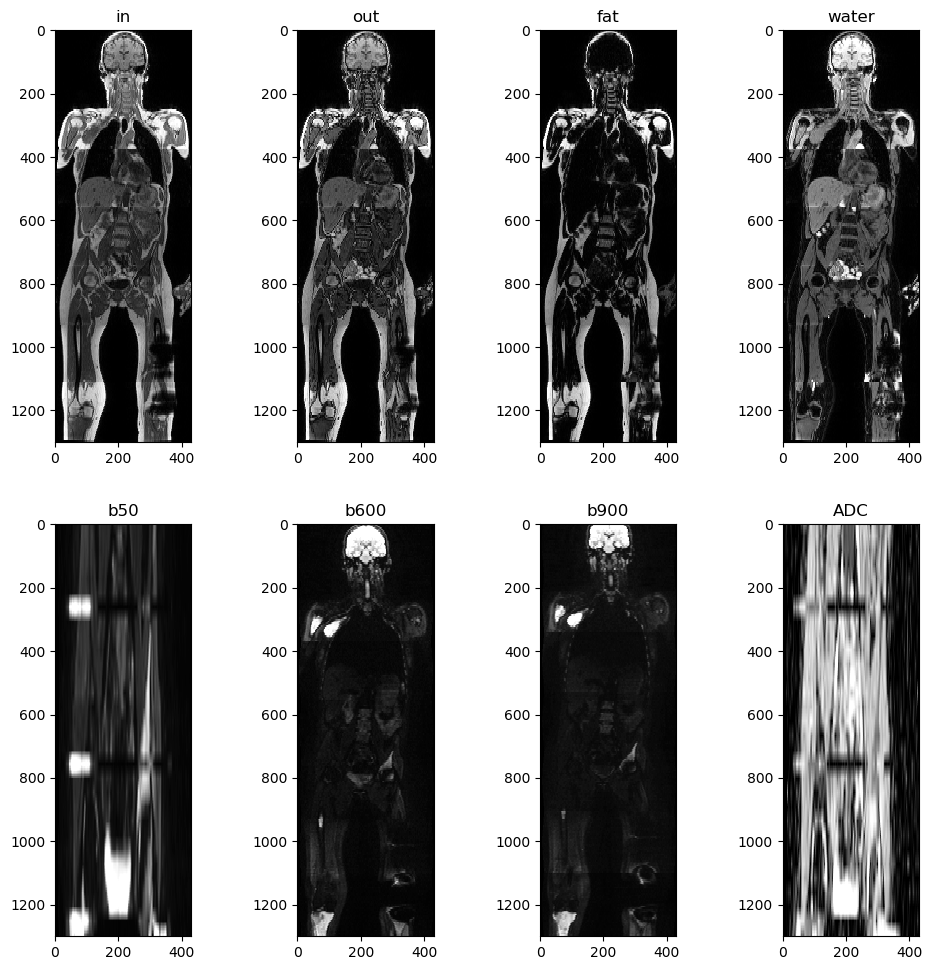

In [25]:
myshow2(imgs_new_2, series_descriptons)

In [60]:
df = pd.read_csv('df.csv')
df.head()

,Sequence,Series,Slice,SeriesNumber,InstanceNumber,SliceLocation,SliceThickness,Rows,Columns,PixelSpacing,ImagePositionPatient,SeriesInstanceUID,SOPInstanceUID,Path
0,diffusion,adc,1,8,1,201.569778,5.0,221,271,"[1.6044776439667, 1.6044776439667]","[-221.14737761021, -179.7265099287, 201.569778...",1.3.12.2.1107.5.2.18.41171.2017101219522271914...,1.3.12.2.1107.5.2.18.41171.2017101219523191324...,temp/dicoms/adc/20171012_190913_Aera/scans/26-...
1,diffusion,adc,2,8,2,196.569778,5.0,221,271,"[1.6044776439667, 1.6044776439667]","[-221.14737761021, -179.7265099287, 196.569778...",1.3.12.2.1107.5.2.18.41171.2017101219522271914...,1.3.12.2.1107.5.2.18.41171.2017101219523190804...,temp/dicoms/adc/20171012_190913_Aera/scans/26-...
2,diffusion,adc,3,8,3,191.569778,5.0,221,271,"[1.6044776439667, 1.6044776439667]","[-221.14737761021, -179.7265099287, 191.569778...",1.3.12.2.1107.5.2.18.41171.2017101219522271914...,1.3.12.2.1107.5.2.18.41171.2017101219523190284...,temp/dicoms/adc/20171012_190913_Aera/scans/26-...
3,diffusion,adc,4,8,4,186.569778,5.0,221,271,"[1.6044776439667, 1.6044776439667]","[-221.14737761021, -179.7265099287, 186.569778...",1.3.12.2.1107.5.2.18.41171.2017101219522271914...,1.3.12.2.1107.5.2.18.41171.2017101219523189760...,temp/dicoms/adc/20171012_190913_Aera/scans/26-...
4,diffusion,adc,5,8,5,181.569778,5.0,221,271,"[1.6044776439667, 1.6044776439667]","[-221.14737761021, -179.7265099287, 181.569778...",1.3.12.2.1107.5.2.18.41171.2017101219522271914...,1.3.12.2.1107.5.2.18.41171.2017101219523189238...,temp/dicoms/adc/20171012_190913_Aera/scans/26-...


In [61]:
df.set_index(['Sequence', 'Series', 'InstanceNumber'], drop=False, inplace=True)
df.drop(['Sequence', 'Series'], axis=1, inplace=True)  # Keep InstanceNumber column
df.rename_axis(index={'InstanceNumber': 'Slice'}, inplace=True)

In [63]:
df.head()

Slice  SeriesNumber  InstanceNumber  SliceLocation  \
Sequence  Series Slice                                                       
diffusion adc    1          1             8               1     201.569778   
                 2          2             8               2     196.569778   
                 3          3             8               3     191.569778   
                 4          4             8               4     186.569778   
                 5          5             8               5     181.569778   

                        SliceThickness  Rows  Columns  \
Sequence  Series Slice                                  
diffusion adc    1                 5.0   221      271   
                 2                 5.0   221      271   
                 3                 5.0   221      271   
                 4                 5.0   221      271   
                 5                 5.0   221      271   

                                              PixelSpacing  \
Sequence  Series Slice                                       
diffusion adc    1      [1.6044776439667, 1.6044776439667]   
                 2      [1.6044776439667, 1.6044776439667]   
                 3      [1.6044776439667, 1.6044776439667]   
                 4      [1.6044776439667, 1.6044776439667]   
                 5      [1.6044776439667, 1.6044776439667]   

                                                     ImagePositionPatient  \
Sequence  Series Slice                                                      
diffusion adc    1      [-221.14737761021, -179.7265099287, 201.569778...   
                 2      [-221.14737761021, -179.7265099287, 196.569778...   
                 3      [-221.14737761021, -179.7265099287, 191.569778...   
                 4      [-221.14737761021, -179.7265099287, 186.569778...   
                 5      [-221.14737761021, -179.7265099287, 181.569778...   

                                                        SeriesInstanceUID  \
Sequence  Series Slice                                                      
diffusion adc    1      1.3.12.2.1107.5.2.18.41171.2017101219522271914...   
                 2      1.3.12.2.1107.5.2.18.41171.2017101219522271914...   
                 3      1.3.12.2.1107.5.2.18.41171.2017101219522271914...   
                 4      1.3.12.2.1107.5.2.18.41171.2017101219522271914...   
                 5      1.3.12.2.1107.5.2.18.41171.2017101219522271914...   

                                                           SOPInstanceUID  \
Sequence  Series Slice                                                      
diffusion adc    1      1.3.12.2.1107.5.2.18.41171.2017101219523191324...   
                 2      1.3.12.2.1107.5.2.18.41171.2017101219523190804...   
                 3      1.3.12.2.1107.5.2.18.41171.2017101219523190284...   
                 4      1.3.12.2.1107.5.2.18.41171.2017101219523189760...   
                 5      1.3.12.2.1107.5.2.18.41171.2017101219523189238...   

                                                                     Path  
Sequence  Series Slice                                                     
diffusion adc    1      temp/dicoms/adc/20171012_190913_Aera/scans/26-...  
                 2      temp/dicoms/adc/20171012_190913_Aera/scans/26-...  
                 3      temp/dicoms/adc/20171012_190913_Aera/scans/26-...  
                 4      temp/dicoms/adc/20171012_190913_Aera/scans/26-...  
                 5      temp/dicoms/adc/20171012_190913_Aera/scans/26-...

In [64]:
df.loc[['diffusion','adc'],'SliceLocation'].diff().min()

-19.524345397950015

load pixel data into dataframe:

In [65]:
df['PixelArray'] = df.Path.apply(lambda x: pydicom.dcmread(x).pixel_array)

In [66]:
df.head()

Slice  SeriesNumber  InstanceNumber  SliceLocation  \
Sequence  Series Slice                                                       
diffusion adc    1          1             8               1     201.569778   
                 2          2             8               2     196.569778   
                 3          3             8               3     191.569778   
                 4          4             8               4     186.569778   
                 5          5             8               5     181.569778   

                        SliceThickness  Rows  Columns  \
Sequence  Series Slice                                  
diffusion adc    1                 5.0   221      271   
                 2                 5.0   221      271   
                 3                 5.0   221      271   
                 4                 5.0   221      271   
                 5                 5.0   221      271   

                                              PixelSpacing  \
Sequence  Series Slice                                       
diffusion adc    1      [1.6044776439667, 1.6044776439667]   
                 2      [1.6044776439667, 1.6044776439667]   
                 3      [1.6044776439667, 1.6044776439667]   
                 4      [1.6044776439667, 1.6044776439667]   
                 5      [1.6044776439667, 1.6044776439667]   

                                                     ImagePositionPatient  \
Sequence  Series Slice                                                      
diffusion adc    1      [-221.14737761021, -179.7265099287, 201.569778...   
                 2      [-221.14737761021, -179.7265099287, 196.569778...   
                 3      [-221.14737761021, -179.7265099287, 191.569778...   
                 4      [-221.14737761021, -179.7265099287, 186.569778...   
                 5      [-221.14737761021, -179.7265099287, 181.569778...   

                                                        SeriesInstanceUID  \
Sequence  Series Slice                                                      
diffusion adc    1      1.3.12.2.1107.5.2.18.41171.2017101219522271914...   
                 2      1.3.12.2.1107.5.2.18.41171.2017101219522271914...   
                 3      1.3.12.2.1107.5.2.18.41171.2017101219522271914...   
                 4      1.3.12.2.1107.5.2.18.41171.2017101219522271914...   
                 5      1.3.12.2.1107.5.2.18.41171.2017101219522271914...   

                                                           SOPInstanceUID  \
Sequence  Series Slice                                                      
diffusion adc    1      1.3.12.2.1107.5.2.18.41171.2017101219523191324...   
                 2      1.3.12.2.1107.5.2.18.41171.2017101219523190804...   
                 3      1.3.12.2.1107.5.2.18.41171.2017101219523190284...   
                 4      1.3.12.2.1107.5.2.18.41171.2017101219523189760...   
                 5      1.3.12.2.1107.5.2.18.41171.2017101219523189238...   

                                                                     Path  \
Sequence  Series Slice                                                      
diffusion adc    1      temp/dicoms/adc/20171012_190913_Aera/scans/26-...   
                 2      temp/dicoms/adc/20171012_190913_Aera/scans/26-...   
                 3      temp/dicoms/adc/20171012_190913_Aera/scans/26-...   
                 4      temp/dicoms/adc/20171012_190913_Aera/scans/26-...   
                 5      temp/dicoms/adc/20171012_190913_Aera/scans/26-...   

                                                               PixelArray  
Sequence  Series Slice                                                     
diffusion adc    1      [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
                 2      [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
                 3      [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
                 4      [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
                 5      [[

create slice spacing (diff) column and delete duplicate slices

In [92]:
for idx, df_select in df.groupby(['Sequence', 'Series']):
    df.loc[idx, 'diff'] = df_select['SliceLocation'].diff().round(2)
    df.loc[idx][df.loc[idx,'diff'] == 0]['Path'].apply(lambda x: os.remove(x))  # remove duplicates
    print(idx, ' - Removed', len(df.loc[idx][df.loc[idx,'diff'] == 0]), 'duplicates')
df = df[df['diff'] != 0]  # drop duplicate rows

In [156]:
df

Slice  SeriesNumber  InstanceNumber  SliceLocation  \
Sequence  Series Slice                                                       
diffusion adc    1          1             8               1     201.569778   
                 2          2             8               2     196.569778   
                 3          3             8               3     191.569778   
                 4          4             8               4     186.569778   
                 5          5             8               5     181.569778   
                 6          6             8               6     176.569778   
                 7          7             8               7     171.569778   
                 8          8             8               8     166.569775   
                 9          9             8               9     161.569775   
                 10        10             8              10     156.569775   
                 11        11             8              11     151.569775   
                 12        12             8              12     146.569775   
                 13        13             8              13     141.569775   
                 14        14             8              14     136.569775   
                 15        15             8              15     131.569777   
                 16        16             8              16     126.569777   
                 17        17             8              17     121.569777   
                 18        18             8              18     116.569776   
                 19        19             8              19     111.569776   
                 20        20             8              20     106.569776   
                 21        21             8              21     101.569776   
                 22        22             8              22      96.569776   
                 23        23             8              23      91.569776   
                 24        24             8              24      86.569777   
                 25        25             8              25      81.569777   
                 26        26             8              26      76.569777   
                 27        27             8              27      71.569775   
                 28        28             8              28      66.569775   
                 29        29             8              29      61.569775   
                 30        30             8              30      56.569775   
...                       ...           ...             ...            ...   
dixon     water  231      231             4             231    -957.430224   
                 232      232             4             232    -962.430224   
                 233      233             4             233    -967.430224   
                 234      234             4             234    -972.430224   
                 235      235             4             235    -977.430224   
                 236      236             4             236    -982.430224   
                 237      237             4             237    -987.430224   
                 238      238             4             238    -992.430224   
                 239      239             4             239    -997.430224   
                 240      240             4             240   -1002.430224   
                 241      241             4             241   -1007.430224   
                 242      242             4             242   -1012.430224   
                 243      243             4             243   -1017.430224   
                 244      244             4             244   -1022.430224   
                 245      245             4             245   -1027.430224   
                 246      246             4             246   -1032.430224   
                 247      247             4             247   -1037.430224   
                 248      248             4             248   -1042.430224   
                 249      249             4   

In [121]:
for idx, df_select in df.groupby(['Sequence', 'Series']):
    print(idx, 'middle =', int(len(df.loc[idx])/2))
    print(df.loc[idx][df.loc[idx,'diff'] != -5][['InstanceNumber','diff']])

('diffusion', 'adc') middle = 129
       InstanceNumber   diff
Slice                       
1                   1    NaN
39                 39  -4.48
225               225 -19.52
('diffusion', 'b50') middle = 130
       InstanceNumber   diff
Slice                       
1                   1    NaN
39                 39  -4.48
226               226 -14.52
('diffusion', 'b600') middle = 129
       InstanceNumber   diff
Slice                       
1                   1    NaN
39                 39  -4.48
226               226 -19.52
('diffusion', 'b900') middle = 132
       InstanceNumber  diff
Slice                      
1                   1   NaN
39                 39 -4.48
227               227 -4.52
228               228 -0.48
229               229 -4.52
230               230 -0.48
231               231 -4.52
('dixon', 'fat') middle = 130
       InstanceNumber  diff
Slice                      
1                   1   NaN
39                 39 -9.48
223               223 -9.52
('dix

 calculate which 2 non -5 diff is closet to the middle and then iterate backwards and forward from that respectively
 
 how about this: append the new slices on the end of the dataframe, then reorder them all at the end based on slice location and delete the ones that don't fit on the same uniform grid? you know when you have got to the end of the slices to process as you will hit NA on the diff value. 
 
 giving up on starting form the middle and just going to start from the top..... 

In [168]:
st = 5

In [176]:
for idx, df_select in df.groupby(['Sequence', 'Series']):
    if not all(d == st for d in df.loc[idx, 'diff']):
        for i in range(2 ,len(df.loc[idx])):
            if df.loc[idx, 'diff'].iloc[i] != st*-1:
                s_prev = df.loc[idx + (i-1,)]
                s = df.loc[idx + (i,)]  # copy row
                s_next = df.loc[idx + (i,)]
            elif df.loc[idx, 'diff'].iloc[i] == st*-1:
                continue
            else:
                print('something went wrong... slices not in right order?')
                

things that need to change:
slice = i + len
instance number = i + len
slice location = new one
ipp[2] = slice location
path = None
pixel array = new one

(not sure what to do with UIDs not, maybe just leave them blank?)

In [ ]:
dataframe.append(pd.DataFrame.from_dict(dict1).unstack()

In [219]:
idx

('dixon', 'water')

In [236]:
i = 1
idx + (i,)

('dixon', 'water', 1)

In [235]:
df.loc[idx + (1,)]

Slice                                                                   1
SeriesNumber                                                            4
InstanceNumber                                                          1
SliceLocation                                                      201.57
SliceThickness                                                          5
Rows                                                                  384
Columns                                                               512
PixelSpacing                                             [0.8398, 0.8398]
ImagePositionPatient    [-218.72945685272, -163.67333027039, 201.56977...
SeriesInstanceUID       1.3.12.2.1107.5.2.18.41171.2017101219573215554...
SOPInstanceUID          1.3.12.2.1107.5.2.18.41171.2017101219573649164...
Path                    temp/dicoms/water/20171012_190913_Aera/scans/5...
PixelArray              [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
diff                                  

In [215]:
a = df.loc[('diffusion','adc',1)]

In [216]:
a['SliceLocation'] = 202

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Slice                                                                   1
SeriesNumber                                                            8
InstanceNumber                                                          1
SliceLocation                                                         202
SliceThickness                                                          5
Rows                                                                  221
Columns                                                               271
PixelSpacing                           [1.6044776439667, 1.6044776439667]
ImagePositionPatient    [-221.14737761021, -179.7265099287, 201.569778...
SeriesInstanceUID       1.3.12.2.1107.5.2.18.41171.2017101219522271914...
SOPInstanceUID          1.3.12.2.1107.5.2.18.41171.2017101219523191324...
Path                    temp/dicoms/adc/20171012_190913_Aera/scans/26-...
PixelArray              [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
diff                                  

In [217]:
df2.loc[('diffusion', 'adc',263)] = a

In [218]:
df2.loc[('diffusion', 'adc',263)]

Slice                                                                   1
SeriesNumber                                                            8
InstanceNumber                                                          1
SliceLocation                                                         202
SliceThickness                                                          5
Rows                                                                  221
Columns                                                               271
PixelSpacing                           [1.6044776439667, 1.6044776439667]
ImagePositionPatient    [-221.14737761021, -179.7265099287, 201.569778...
SeriesInstanceUID       1.3.12.2.1107.5.2.18.41171.2017101219522271914...
SOPInstanceUID          1.3.12.2.1107.5.2.18.41171.2017101219523191324...
Path                    temp/dicoms/adc/20171012_190913_Aera/scans/26-...
Name: (diffusion, adc, 263), dtype: object

In [174]:
for idx, df_select in df.groupby(['Sequence', 'Series']):
    if not all(d == st for d in df.loc[idx, 'diff']):
        for i in range(2 ,len(df.loc[idx])):
            if df.loc[idx, 'diff'].iloc[i] != st*-1:
                print(df.loc[idx, 'diff'].iloc[i])
            

-4.48
-19.52
-4.48
-14.52
-4.48
-19.52
-4.48
-4.52
-0.48
-4.52
-0.48
-4.52
-9.48
-9.52
-9.48
-9.52
-9.48
-9.52
-9.48
-9.52


In [167]:
# remember df.loc[idx] = df_select
for idx, df_select in df.groupby(['Sequence', 'Series']):
    if not all(d == st for d in df.loc[idx, diff]):
        middle = int(len(df.loc[idx])/2)  # find middle of series
        defects = df.loc[idx][df.loc[idx,'diff'] != st*-1].index  # list of indices of non slice width spaces
        start = min(defects, key=lambda x:abs(x-middle)) # closest defect to middle
        if (start - middle) > 0:  # if the start is past the middle
            for i in range(start-1,len(df.loc[idx])+1):  # work downwards (increasing insantce/decreasing slice position)
                print(i)
        else:  # if the start is before the middle or the same
            for i in range(start,0,-1):
                print(i)
        

39
38
37
36
35
34
33
32
31
30
29
28
27
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
39
38
37
36
35
34
33
32
31
30
29
28
27
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
39
38
37
36
35
34
33
32
31
30
29
28
27
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
39
38
37
36
35
34
33
32
31
30
29
28
27
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
39
38
37
36
35
34
33
32
31
30
29
28
27
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
39
38
37
36
35
34
33
32
31
30
29
28
27
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
39
38
37
36
35
34
33
32
31
30
29
28
27
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
39
38
37
36
35
34
33
32
31
30
29
28
27
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
